In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision
import torchvision.models as models
from torchvision import models, transforms, datasets
import torch.optim as optim
import os, pickle, time, copy, glob
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import argparse
import json



In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:

transformers = {'train_transforms' : transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]),
'test_transforms' : transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])}

trans = ['train_transforms','test_transforms']
path = "/content/gdrive/My Drive/Colab Notebooks/MainData/"
categories = ['train','test']

In [ ]:
dset = {x : torchvision.datasets.ImageFolder(path+x, transform=transformers[y]) for x,y in zip(categories, trans)}


In [ ]:

len_train = len(dset['train'])
print('original train dataset size ', len_train) 
len_test = len(dset['test'])
print('original test dataset size ', len_test) 

indices_list = range(len_train)
indices = [*indices_list]


np.random.shuffle(indices)

split = int(np.floor(0.2 * len_train))
train_idx, valid_idx = indices[split:], indices[:split]
print('Upadted train dataset size:', len(train_idx))
print('Created validation dataset size:', len(valid_idx))
test_idx = [i for i in range(len(dset['test']))]
print('the test imagedataest size', len(dset['test']))


train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

dataset_sizes = {}
dataset_sizes['train'] = train_sampler.__len__()
dataset_sizes['test'] = test_sampler.__len__()
dataset_sizes['val'] = valid_sampler.__len__()
print(dataset_sizes['val'], dataset_sizes['test'], dataset_sizes['train'])


original train dataset size  2031
original test dataset size  3040
Upadted train dataset size: 1625
Created validation dataset size: 406
the test imagedataest size 3040
406 3040 1625


In [ ]:

train_loader = torch.utils.data.DataLoader(dset['train'], batch_size=16,
    drop_last= True, sampler=train_sampler, num_workers=0)
valid_loader = torch.utils.data.DataLoader(dset['train'], batch_size=16, 
    drop_last= True, sampler=valid_sampler, num_workers=0)
test_loader = torch.utils.data.DataLoader(dset['test'], batch_size=16, 
    drop_last= True,sampler=test_sampler,num_workers=0)


In [ ]:
dataloaders = {'train':train_loader,'val':valid_loader,'test':test_loader}
class_names = dset['train'].classes

In [ ]:
images, labels = next(iter(dataloaders['test']))
rand_idx = np.random.randint(len(images))
# print(rand_idx)
print("label: {}, class: {}".format(labels[rand_idx].item(),
                                               class_names[labels[rand_idx].item()]))

label: 0, class: covid-n


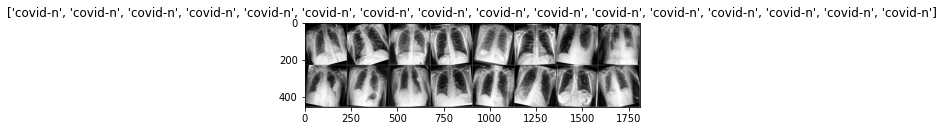

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std*inp + mean
    inp = np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
inputs,classes = next(iter(dataloaders["train"]))
out = torchvision.utils.make_grid(inputs)
class_names = dset["train"].classes
imshow(out, title = [class_names[x] for x in classes])


In [ ]:
class ModelVGG16(nn.Module):
    def __init__(self):
        super(ModelVGG16, self).__init__()
        self.model = torchvision.models.vgg16(pretrained=True)
        self.classifier = nn.Sequential(
        nn.Linear(4096,2),
        nn.LogSoftmax(dim=1))
        for params in self.model.parameters():
            params.requires_grad = False
        self.model.classifier[6] = self.classifier

    def forward(self, x):
        return self.model(x)
        

model = ModelVGG16()

In [ ]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []
def fit(self, dataloaders, num_epochs):


        train_on_gpu = torch.cuda.is_available()
 
        optimizer = optim.Adam(model.parameters(), lr=0.01)
     
        scheduler = optim.lr_scheduler.StepLR(optimizer, 4)
     
        criterion = nn.NLLLoss()
        since = time.time()

        best_model_wts = copy.deepcopy(self.model.state_dict())
        best_acc = 0.0

        if train_on_gpu:
            self.model = self.model.cuda()
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
       
            for phase in ['train', 'val']:
               
                if phase == 'train':
                    scheduler.step()
                    self.model.train()  
                else:
                    self.model.eval()   
                running_loss = 0.0
                running_corrects = 0
         
                for inputs, labels in dataloaders[phase]:
                    if train_on_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
                    
                    optimizer.zero_grad()
                    
                  
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        #calculates the loss between the output of our model and ground-truth labels
                        loss = criterion(outputs, labels)

                        # perform backpropagation and optimization only if in training phase
                        if phase == 'train':
                            #backpropagate gradients from the loss node through all the parameters
                            loss.backward()
                            #Update parameters(Weighs and biases) of our model using the gradients.
                            optimizer.step()
                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch_loss, epoch_acc))

                if(phase == 'train'):
                  train_losses.append(epoch_loss)   
                  train_acc.append(epoch_acc) 
                if(phase == 'val'):
                  val_losses.append(epoch_loss)   
                  val_acc.append(epoch_acc) 
     
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(self.model.state_dict())
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))
        
      
        self.model.load_state_dict(best_model_wts)
        return self.model


In [ ]:
num_epochs = 5
model1_vgg16 = fit(model, dataloaders, num_epochs)

Epoch 0/4
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.3713 Acc: 0.9717
val Loss: 0.2916 Acc: 0.9680
Epoch 1/4
----------
train Loss: 0.2279 Acc: 0.9742
val Loss: 0.0325 Acc: 0.9803
Epoch 2/4
----------
train Loss: 0.2599 Acc: 0.9760
val Loss: 0.7520 Acc: 0.9655
Epoch 3/4
----------
train Loss: 0.3852 Acc: 0.9822
val Loss: 0.1713 Acc: 0.9729
Epoch 4/4
----------
train Loss: 0.2221 Acc: 0.9803
val Loss: 0.0567 Acc: 0.9803
Training complete in 16m 31s
Best val Acc: 0.980296


In [ ]:
model1_vgg16.eval()
torch.save(model1_vgg16, '/content/gdrive/My Drive/Colab Notebooks/vgg16_model1_without_aug.pt')

In [ ]:
num_epochs = 10
model2_vgg16 = fit(model, dataloaders, num_epochs)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.2312 Acc: 0.9766
val Loss: 0.1941 Acc: 0.9754
Epoch 1/9
----------
train Loss: 0.2569 Acc: 0.9785
val Loss: 0.0271 Acc: 0.9828
Epoch 2/9
----------
train Loss: 0.2940 Acc: 0.9766
val Loss: 0.0209 Acc: 0.9778
Epoch 3/9
----------
train Loss: 0.1393 Acc: 0.9822
val Loss: 0.0579 Acc: 0.9778
Epoch 4/9
----------
train Loss: 0.1685 Acc: 0.9772
val Loss: 0.0432 Acc: 0.9828
Epoch 5/9
----------
train Loss: 0.1239 Acc: 0.9840
val Loss: 0.0729 Acc: 0.9729
Epoch 6/9
----------
train Loss: 0.1984 Acc: 0.9809
val Loss: 0.0444 Acc: 0.9778
Epoch 7/9
----------
train Loss: 0.1548 Acc: 0.9840
val Loss: 0.0254 Acc: 0.9828
Epoch 8/9
----------
train Loss: 0.1514 Acc: 0.9840
val Loss: 0.0315 Acc: 0.9803
Epoch 9/9
----------
train Loss: 0.1384 Acc: 0.9828
val Loss: 0.0105 Acc: 0.9803
Training complete in 2m 47s
Best val Acc: 0.982759


In [ ]:
model2_vgg16.eval()
torch.save(model2_vgg16, '/content/gdrive/My Drive/Colab Notebooks/vgg16_model2_without_aug.pt')

In [ ]:
num_epochs = 15
model3_vgg16 = fit(model, dataloaders, num_epochs)

Epoch 0/14
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.4083 Acc: 0.9766
val Loss: 0.0381 Acc: 0.9754
Epoch 1/14
----------
train Loss: 0.1785 Acc: 0.9766
val Loss: 0.0937 Acc: 0.9704
Epoch 2/14
----------
train Loss: 0.2410 Acc: 0.9754
val Loss: 0.4089 Acc: 0.9680
Epoch 3/14
----------
train Loss: 0.2034 Acc: 0.9828
val Loss: 0.0092 Acc: 0.9803
Epoch 4/14
----------
train Loss: 0.1116 Acc: 0.9754
val Loss: 0.0039 Acc: 0.9828
Epoch 5/14
----------
train Loss: 0.1272 Acc: 0.9840
val Loss: 0.0050 Acc: 0.9803
Epoch 6/14
----------
train Loss: 0.1086 Acc: 0.9815
val Loss: 0.0012 Acc: 0.9852
Epoch 7/14
----------
train Loss: 0.1368 Acc: 0.9803
val Loss: 0.0385 Acc: 0.9754
Epoch 8/14
----------
train Loss: 0.0885 Acc: 0.9834
val Loss: 0.0154 Acc: 0.9803
Epoch 9/14
----------
train Loss: 0.0976 Acc: 0.9822
val Loss: 0.0000 Acc: 0.9852
Epoch 10/14
----------
train Loss: 0.1264 Acc: 0.9791
val Loss: 0.0210 Acc: 0.9828
Epoch 11/14
----------
train Loss: 0.1312 Acc: 0.9791
val Loss: 0.0155 Acc: 0.9778
Epoch 12/14
----------
train Loss: 0

In [ ]:
model3_vgg16.eval()
torch.save(model3_vgg16, '/content/gdrive/My Drive/Colab Notebooks/vgg16_model3_without_aug.pt')

In [ ]:
num_epochs = 20
model4_vgg16 = fit(model, dataloaders, num_epochs)

Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.2988 Acc: 0.9766
val Loss: 0.3186 Acc: 0.9729
Epoch 1/19
----------
train Loss: 0.2695 Acc: 0.9754
val Loss: 0.2593 Acc: 0.9729
Epoch 2/19
----------
train Loss: 0.3120 Acc: 0.9803
val Loss: 0.0498 Acc: 0.9778
Epoch 3/19
----------
train Loss: 0.1294 Acc: 0.9852
val Loss: 0.0451 Acc: 0.9803
Epoch 4/19
----------
train Loss: 0.1609 Acc: 0.9834
val Loss: 0.0216 Acc: 0.9803
Epoch 5/19
----------
train Loss: 0.1969 Acc: 0.9785
val Loss: 0.0662 Acc: 0.9754
Epoch 6/19
----------
train Loss: 0.1971 Acc: 0.9803
val Loss: 0.0332 Acc: 0.9828
Epoch 7/19
----------
train Loss: 0.2078 Acc: 0.9834
val Loss: 0.0204 Acc: 0.9828
Epoch 8/19
----------
train Loss: 0.1064 Acc: 0.9865
val Loss: 0.0767 Acc: 0.9754
Epoch 9/19
----------
train Loss: 0.1010 Acc: 0.9840
val Loss: 0.0061 Acc: 0.9828
Epoch 10/19
----------
train Loss: 0.1652 Acc: 0.9822
val Loss: 0.0800 Acc: 0.9754
Epoch 11/19
----------
train Loss: 0.2003 Acc: 0.9815
val Loss: 0.0269 Acc: 0.9803
Epoch 12/19
----------
train Loss: 0

In [ ]:
model4_vgg16.eval()
torch.save(model4_vgg16, '/content/gdrive/My Drive/Colab Notebooks/vgg16_model4_without_aug.pt')

In [ ]:
num_epochs = 25
model5_vgg16 = fit(model, dataloaders, num_epochs)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.4513 Acc: 0.9668
val Loss: 0.0201 Acc: 0.9754
Epoch 1/24
----------
train Loss: 0.2476 Acc: 0.9711
val Loss: 0.0028 Acc: 0.9828
Epoch 2/24
----------
train Loss: 0.2119 Acc: 0.9772
val Loss: 0.0009 Acc: 0.9852
Epoch 3/24
----------
train Loss: 0.1706 Acc: 0.9778
val Loss: 0.0144 Acc: 0.9778
Epoch 4/24
----------
train Loss: 0.2161 Acc: 0.9778
val Loss: 0.0257 Acc: 0.9803
Epoch 5/24
----------
train Loss: 0.1394 Acc: 0.9809
val Loss: 0.0167 Acc: 0.9828
Epoch 6/24
----------
train Loss: 0.0895 Acc: 0.9809
val Loss: 0.0007 Acc: 0.9852
Epoch 7/24
----------
train Loss: 0.1147 Acc: 0.9785
val Loss: 0.0163 Acc: 0.9803
Epoch 8/24
----------
train Loss: 0.1884 Acc: 0.9760
val Loss: 0.0063 Acc: 0.9803
Epoch 9/24
----------
train Loss: 0.0757 Acc: 0.9791
val Loss: 0.0042 Acc: 0.9828
Epoch 10/24
----------
train Loss: 0.1256 Acc: 0.9797
val Loss: 0.0005 Acc: 0.9852
Epoch 11/24
----------
train Loss: 0.1378 Acc: 0.9797
val Loss: 0.0034 Acc: 0.9828
Epoch 12/24
----------
train Loss: 0

In [ ]:
model5_vgg16.eval()
torch.save(model5_vgg16, '/content/gdrive/My Drive/Colab Notebooks/vgg_model5_without_aug.pt')